COMIENZA CARGA DE DATOS

Cargo en primer lugar las librerias que usaré, luego cargo el set de datos elegido; este contiene datos de siniestros de tránsito en la Ciudad de Buenos Aires, entre los años 2015 y 2018. 

In [63]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [64]:
siniestros = 'victimas-siniestros.csv'
sin_df = pd.read_csv(siniestros)

C:\Users\Seguridad\AppData\Local\Temp\ipykernel_2836\1239150759.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  sin_df = pd.read_csv(siniestros)


COMIENZA EL PROCESO DE LIMPIEZA DEL DATASET

In [65]:
sin_df.sample(3)

,causa,rol,tipo,sexo,edad,mes,periodo,fecha,hora,lugar_hecho,...,semestre,x,y,geom,cantidad_victimas,comuna,geom_3857,tipo_colision1,participantes_victimas,participantes_acusados
23060,lesiones,peaton,peaton,femenino,28.0,7.0,2017,7/18/2017,17:00:00,avda ing huergo y avda san juan,...,2,-58.366072,-34.621507,0101000020E6100000DA7FDE6EDB2E4DC0D2C7D38E8D4F...,1,1.0,0101000020110F00006E67725700C958C140E296DF5960...,peaton - vehiculo,peaton,automovil
7143,lesiones,pasajero,transporte publico,femenino,63.0,11.0,2017,11-03-17,21:45:00,av pueyrredon 678,...,2,-58.404986,-34.602189,0101000020E6100000D662AF94D6334DC06E9AD486144D...,1,3.0,0101000020110F0000CBC32F533BCD58C1E60EC1613F5B...,vehiculo - vehiculo,"""transporte publico""","""transporte publico"""
4164,lesiones,conductor,automovil,masculino,61.0,8.0,2016,8/24/2016,7:40:00,avda ing huergo & estados unidos,...,2,-58.366456,-34.618119,0101000020E6100000F0B64507E82E4DC01B662F851E4F...,2,1.0,0101000020110F0000B7FBEE090BC958C190A03FAF745F...,multiple,"automovil,moto","automovil,moto"


In [66]:
sin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33234 entries, 0 to 33233
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   causa                         33234 non-null  object 
 1   rol                           32899 non-null  object 
 2   tipo                          32134 non-null  object 
 3   sexo                          33037 non-null  object 
 4   edad                          32675 non-null  float64
 5   mes                           33197 non-null  float64
 6   periodo                       33234 non-null  int64  
 7   fecha                         33173 non-null  object 
 8   hora                          33217 non-null  object 
 9   lugar_hecho                   29518 non-null  object 
 10  direccion_normalizada         32469 non-null  object 
 11  tipo_calle                    33234 non-null  object 
 12  direccion_normalizada_arcgis  32462 non-null  object 
 13  c

EN PRIMERA INSTANCIA DE LA EXPLORACION, VOY A ESTABLECER UN OBJETIVO GENERAL:

- QUIERO MINIMIZAR LA CANTIDAD DE ACCIDENTES DE AUTOS, MOTOS Y BICICLETAS (en este ejemplo me contrataría gobierno de la Ciudad de Buenos Aires). PARA ESTO HABRIA QUE TOMAR MEDIDAS DE TODO TIPO, COMO CONTROLES POLICIALES, CARTELES PREVENTIVOS, ARREGLOS DE CALLE, CAMARAS-MULTA, ETC.

-------------------------------------------------------------------------------------------------------------------------------

CON ESTE OBJETIVO EN MENTE, VOY A ELEGIR QUE COLUMNAS SON LAS QUE MAS INFORMACION PUEDEN APORTAR Y CUALES SON LAS QUE TIENEN INFORMACION REDUNDANTE.

EN UNA PRIMERA IMPRESION, ASUMO QUE LAS COLUMNAS MAS IMPORTANTES SON:

- causa
- rol
- tipo
- sexo
- edad
- fecha
- hora
- tipo_calle
- calle1
- calle2
- x
- y
- cantidad_victimas
- comuna
- participantes_victimas
- participantes_acusados

EL RESTO DE COLUMAS CONTIENEN INFORMACION QUE APARECE EN ESTAS COLUMNAS SELECCIONADAS, PERO EN OTRO FORMATO.

PROCEDO A QUEDARME SOLO CON LAS COLUMNAS ELEGIDAS Y REVISO LOS DATOS NULOS

In [67]:
sin_df = sin_df[['causa','rol','tipo','sexo','edad','fecha','hora','tipo_calle','calle1','calle2','x','y','cantidad_victimas','comuna','tipo_colision1','participantes_acusados','participantes_victimas']]
sin_df.isnull().sum()

causa                        0
rol                        335
tipo                      1100
sexo                       197
edad                       559
fecha                       61
hora                        17
tipo_calle                   0
calle1                     765
calle2                    8247
x                         1095
y                         1095
cantidad_victimas            0
comuna                    1098
tipo_colision1            1343
participantes_acusados     677
participantes_victimas    1131
dtype: int64

In [68]:
sin_df.loc[sin_df.comuna.isnull()][['causa','rol','tipo','sexo','edad','fecha','hora','tipo_calle','calle1','calle2','x','y','cantidad_victimas','comuna','tipo_colision1','participantes_acusados','participantes_victimas']].isnull().sum()

causa                        0
rol                          6
tipo                        41
sexo                         6
edad                        29
fecha                        6
hora                         6
tipo_calle                   0
calle1                     739
calle2                    1097
x                         1095
y                         1095
cantidad_victimas            0
comuna                    1098
tipo_colision1              43
participantes_acusados      17
participantes_victimas      38
dtype: int64

BORRO LAS FILAS QUE TIENEN EL CAMPO FECHA Y HORA VACIOS, PORQUE SON MUY POCOS DATOS QUE PIERDO.

In [69]:
sin_df.dropna(subset=['fecha','hora'],inplace=True)
sin_df[['fecha','hora']].isnull().sum()

fecha    0
hora     0
dtype: int64

AHORA VOY A SIMPLIFICAR LAS COLUMNAS 'tipo' Y 'tipo_colision1' PARA QUE SEAN UTILIZABLES.

In [70]:
sin_df['tipo_colision1'].fillna('sin_data',inplace=True)
sin_df['tipo'].fillna('sin_data',inplace=True)

def simplificar_tipocol(tipo):

    if '-' in tipo:
        ac, vi = tipo.split('-')
    else:
        return tipo
    
    if tipo == 'vehiculo - motovehiculo' or tipo == 'motovehiculo - vehiculo':
        return 'motovehiculo - vehiculo'
    elif tipo == 'vehiculo - peaton' or tipo == 'peaton - vehiculo':
        return 'peaton - vehiculo'
    elif tipo == 'vehiculo - bicicleta' or tipo == 'bicicleta - vehiculo':
        return 'bicicleta - vehiculo'
    elif tipo == 'traccion a sangre - vehiculo' or tipo == 'motovehiculo - traccion a sangre' or tipo == 'motovehiculo - tren' or tipo == 'subte - vehiculo':
        return 'sin_data'
    elif 'bicicleta' in tipo:
        return 'bicicleta'
    elif 'peaton' in tipo:
        return 'peaton'
    else:
        return tipo

def simplificar_tipo(tipo):
    
    if tipo == 'auto pfa / movil / gendarmeria / metropolitana / moto movil' or tipo == 'vehiculo oficial':
        st = 'fuerza seguridad'
    elif tipo == 'transporte de cargas / grua' or tipo == 'utilitario':
        st = 'camion'
    elif tipo == 'transporte escolar' or tipo == 'omnibus / minibus':
        st = 'transporte publico'
    elif tipo == 'ambulancia':
        st = 'camioneta'
    elif tipo == 'traccion a sangre' or tipo == 'autobomba' or tipo == 'patineta' or tipo == 'cuatriciclo' or tipo == 'tren / subte' or tipo == 'tren / subte / tranvia' or tipo == 'vehiculo rural' or tipo == 'otros':
        st = 'sin_data'
    else:
        return tipo
    return st

In [71]:
sin_df['tipo'] = sin_df['tipo'].apply(simplificar_tipo)#.astype('|S80')

sin_df['tipo_colision1'] = sin_df['tipo_colision1'].apply(simplificar_tipocol)#.astype('|S80')

sin_df[['tipo','tipo_colision1']].describe()

,tipo,tipo_colision1
count,33162,33162
unique,10,9
top,moto,motovehiculo - vehiculo
freq,12989,11378


DEBERIA RELLENAR LOS NULOS DE 'tipo' CON INFORMACION DE OTRAS COLUMNAS PARA MEJORAR LA CALIDAD DE LA INFORMACION

AHORA VOY A RELLENAR LOS CAMPOS CON VALOR NULO

In [72]:
#sin_df['comuna'].fillna(0,inplace=True)
sin_df = sin_df.dropna(subset='comuna')
sin_df['comuna'] = sin_df['comuna'].astype(int)

In [73]:
sin_df['rol'].fillna('sin_data',inplace=True)
sin_df['sexo'].fillna('sin_data',inplace=True)
sin_df['calle1'].fillna('sin_data',inplace=True)
sin_df['calle2'].fillna('sin_data',inplace=True)
sin_df['participantes_acusados'].fillna('sin_data',inplace=True)
sin_df['participantes_victimas'].fillna('sin_data',inplace=True)
sin_df['x'].fillna(-1,inplace=True)
sin_df['y'].fillna(-1,inplace=True)
sin_df['edad'].fillna(sin_df.edad.mean(),inplace=True)

EN LOS SIGUIENTES CASILLEROS VOY A LIMPIAR Y NORMALIZAR COLUMNAS

In [74]:
def normalizar_causa(causa):
    if causa == 'lesiones':
        return 1
    elif causa == 'homicidio':
        return 2
    else:
        return 0


def normalizar_sexo(sexo):
    if sexo == 'masculino':
        return 1
    elif sexo == 'femenino':
        return 2
    else:
        return 0
    
def normalizar_tipo_calle(calle):
    if calle == 'autopista':
        return 1
    elif calle == 'avenida':
        return 2
    elif calle == 'calle':
        return 3
    else:
        return 0
    
sin_df['sexo'] = sin_df['sexo'].apply(normalizar_sexo)
sin_df['causa'] = sin_df['causa'].apply(normalizar_causa)
sin_df['tipo_calle'] = sin_df['tipo_calle'].apply(normalizar_tipo_calle)
sin_df.value_counts('tipo_calle')

# masculino -> 1
# femenino -> 2
# sin data -> 0

# lesiones -> 1
# muerte -> 2

tipo_calle
2    21127
3    10838
1      106
dtype: int64

In [75]:
def edades(edad):
    rango = 0
    
    if (edad<20):
        rango=1
    elif (edad<30):
        rango=2
    elif (edad<40):
        rango=3
    elif (edad<50):
        rango=4
    elif (edad<60):
        rango=5
    elif (edad<70):
        rango=6
    else:
        rango=7
    return rango

sin_df['rango_edad'] = sin_df['edad'].apply(edades)
sin_df.value_counts('rango_edad')

rango_edad
2    9878
3    8691
4    4506
1    2808
5    2670
6    1866
7    1652
dtype: int64

LE DOY UN FORMATO DESEADO A LA HORA Y FECHA

In [76]:
def extraer_hora(hora):
    return hora.hour

sin_df['hora'] = pd.to_datetime(sin_df['hora']).apply(extraer_hora)
sin_df['hora'] = sin_df['hora'].astype(int)
sin_df.value_counts('hora').head()

hora
18    2141
13    2129
14    2050
17    2022
12    1967
dtype: int64

In [77]:
def crear_fecha(fecha):

    if "/" in fecha:
        fecha = fecha.split("/")
        fecha[0] = int(fecha[0])
        fecha[1] = int(fecha[1])
        fecha[2] = int(fecha[2])
        aux = fecha[1]
        fecha[1] = fecha[0]
        fecha[0] = aux
        return fecha
    
    elif "-" in fecha:
        fecha = fecha.split("-")
        fecha[0] = int(fecha[0])
        fecha[1] = int(fecha[1])
        fecha[2] = int(fecha[2])
        fecha[2] = 2000 + fecha[2]
        return fecha


def dia(d):
    return d[0]

def mes(d):
    return d[1]

def anio(d):
    return d[2]

In [78]:
sin_df['rango_horario'] = sin_df.hora.apply(lambda x: 
                                            0 if (x < 5)
                                            else 1 if (x < 14)
                                            else 2 if (x < 21)
                                            else 0)

sin_df.rango_horario.value_counts()

# 0 -> Noche y Madrugada
# 1 -> Mañana
# 2 -> Tarde

2    13504
1    12988
0     5579
Name: rango_horario, dtype: int64

In [79]:
#sin_df = sin_df.dropna(subset='fecha')
sin_df['fecha_norm'] = sin_df['fecha'].apply(crear_fecha)

sin_df['d'] = sin_df['fecha_norm'].apply(dia)
sin_df['m'] = sin_df['fecha_norm'].apply(mes)
sin_df['a'] = sin_df['fecha_norm'].apply(anio)

sin_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32071 entries, 0 to 33232
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   causa                   32071 non-null  int64  
 1   rol                     32071 non-null  object 
 2   tipo                    32071 non-null  object 
 3   sexo                    32071 non-null  int64  
 4   edad                    32071 non-null  float64
 5   fecha                   32071 non-null  object 
 6   hora                    32071 non-null  int32  
 7   tipo_calle              32071 non-null  int64  
 8   calle1                  32071 non-null  object 
 9   calle2                  32071 non-null  object 
 10  x                       32071 non-null  float64
 11  y                       32071 non-null  float64
 12  cantidad_victimas       32071 non-null  int64  
 13  comuna                  32071 non-null  int32  
 14  tipo_colision1          32071 non-null

In [80]:
#sin_df[['tipo_colision1','tipo','participantes_acusados','participantes_victimas']].sample(10)
sin_df.participantes_acusados.value_counts()

automovil                                    16212
"transporte publico"                          3660
moto                                          2543
taxi/remis                                    2080
camioneta                                     1400
                                             ...  
taxi/remis,camioneta                             1
moto,automovil,automovil,automovil               1
automovil,ambulancia                             1
"transporte de cargas / grua / volquetes"        1
automovil,cuatriciclo                            1
Name: participantes_acusados, Length: 178, dtype: int64

veo que 'participantes_victimas' contiene en casi todos los casos el mismo valor que la columna 'tipo', por lo cual no la voy a utilizar.
en el caso de la columna 'participantes_acusados' tiene informacion diferente y tendre que limpiar la columna para poder utilizarla.

In [81]:
def simplificar_acusado(ac):    
    if ('moto' in ac):
        return 'motovehiculo'
    elif ('auto' in ac):
        return 'automovil'
    elif (('rural' in ac) | ('camion' in ac) | ('utilitario' in ac)):
        return 'camion'
    elif ('peaton' in ac) | ('patineta' in ac):
        return 'peaton'
    elif ('bici' in ac):
        return 'bicicleta'
    elif (('taxi' in ac) | ('remis' in ac) | ('bus' in ac) | ('publico' in ac)):
        return 'transporte_publico'
    elif (('transporte' in ac) | ('ambulancia' in ac) | ('fuerza' in ac) | ('tren' in ac) | ('tranvia' in ac) | ('oficial' in ac)):
        return 'transporte_publico2'
    else:
        return 'otro'

sin_df.participantes_acusados = sin_df.participantes_acusados.apply(simplificar_acusado)
sin_df.participantes_acusados.value_counts()

automovil              18478
transporte_publico      5944
motovehiculo            3598
camion                  2788
otro                     739
transporte_publico2      256
bicicleta                200
peaton                    68
Name: participantes_acusados, dtype: int64

FINALIZA EL PROCESO DE LIMPIEZA

AGREGO DATOS DEL CLIMA DE CABA PARA SINIESTRO (utilizando como clave la fecha y hora del mismo)



In [82]:
clima = 'clima_caba.csv'
clima_df = pd.read_csv(clima)
clima_df.rename(columns={'viento;;;;;;':'viento'}, inplace=True)

#NO SE PORQUE AGREGA LA COLUMNA VIENTO CON ESE NOMBRE, PARA NO PERDER TIEMPO LA CORRIJO MANUALMENTE

In [83]:
sin_df = sin_df.merge(clima_df,how='left',left_on=['d','m','a','hora'],right_on=['d','m','a','h'])
sin_df.sample(3)

,causa,rol,tipo,sexo,edad,fecha,hora,tipo_calle,calle1,calle2,...,rango_horario,fecha_norm,d,m,a,h,temp,hum,precip,viento
6418,1,conductor,moto,1,27.0,12/20/2017,1,3,o'higgins,sin_data,...,0,"[20, 12, 2017]",20,12,2017,1,19.41,76.12,0.0,2.85
15725,1,ciclista,bicicleta,1,47.0,04-09-18,9,2,cordoba av.,dorrego av.,...,1,"[4, 9, 2018]",4,9,2018,9,13.87,76.31,0.0,4.31
4325,1,peaton,peaton,2,22.0,10/14/2016,15,3,pasco,sin_data,...,2,"[14, 10, 2016]",14,10,2016,15,22.26,72.31,0.0,4.59


<AxesSubplot:>

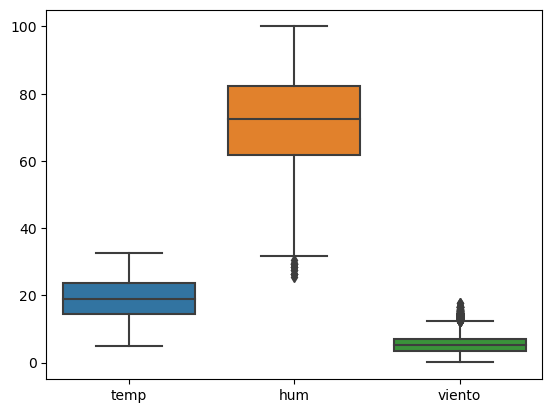

In [84]:
sns.boxplot(sin_df[['temp','hum','viento']])

Veo que en este caso los outliers no cambiaran en gran medida la normalización.

In [85]:
# SE QUE TENGO OUTLIERS EN ESTE FEATURE, HAGO UNA ELIMINACION MANUAL DE ESTOS

sin_df.precip.sort_values(ascending=False).head(30)

24910    40.06
2712     30.38
2711     30.38
7489     26.07
31598    26.07
17609    24.33
1483     24.33
25632    24.33
16838    21.76
154      20.40
16851    18.91
6777     16.31
30755    16.31
6713     16.14
30646    16.14
10460    15.29
10461    15.29
10462    15.29
10459    15.29
30058    14.71
17249    11.57
9057     11.57
2312     10.67
14800    10.62
14472    10.62
4057     10.51
11958    10.51
14125    10.33
20517     9.44
28459     9.44
Name: precip, dtype: float64

In [86]:
#ELIMINO OUTLIERS DE PRECIPITACION PARA QUE NO INTERFIERA EN LA NORMALIZACION DEL FEATURE, CONSIDERO OUTLIERS A LOS VALORES MAYORES A 12
sin_df = sin_df.loc[sin_df.precip < 12]


In [87]:
#ESCALO TODOS LOS VALORES DE CLIMA OBTENIDOS ENTRE 0 y 1
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(sin_df[['temp','hum','viento','precip']])
sin_df[['temp','hum','viento','precip']] = scaled_df

# PUEDO ESCALAR LOS VALORES O PUEDO CATEGORIZARLOS 

EN OTRAS ENTREGAS PUDE EXTRAER INFORMACIÓN DEL SET DE DATOS QUE APUNTABA A ENCONTRAR LOS PUNTOS CLAVE EN LOS QUE SE DABA LA MAYOR CANTIDAD DE SINIESTROS DE CADA TIPO (las calles, comunas y coordenadas mas peligrosas para cada tipo de vehiculo), ESTOS DESCUBRIMIENTOS SON LOS INSIGHTS QUE ME PARECIERON IMPORTANTES EN VISTA A PROPONER MEDIDAS QUE AYUDEN A BAJAR LA CANTIDAD DE ACCIDENTES. 

EN ESTA ENTREGA ME CENTRARÉ EN LA PREDICCIÓN; PARA ESTO VOY A ENTRENAR UN MODELO DE MACHINE LEARNING, HABIENDO HECHO LA SELECCIÓN DE FEATURES QUE CREA NECESARIO PARA EL CASO.

PARA EL PRIMER ESTUDIO, UTILIZARE COMO VARIABLE DEPENDIENTE EL HORARIO, LAS VARIABLES INDEPENDIENTES SERÁN 'tipo','sexo','tipo_calle','comuna','tipo_colision1','d','m','a','precip','rango_edad','participantes_acusados'.

Comienzo con este estudio porque me parece el valor mas útil a predecir dados los features disponibles, ya que esto podría ser de utilidad para entes que regulen y prevengan accidentes de transito. 

In [88]:
X = sin_df[['tipo','sexo','tipo_calle','comuna','tipo_colision1','d','m','a','participantes_acusados','precip','viento','rango_edad','rol']]
y = sin_df['rango_horario']
#CON DATOS DE CLIMA

In [89]:
#X = pd.get_dummies(X)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(X.rol)
X.rol = le.transform(X.rol)

le.fit(X.tipo_colision1)
X.tipo_colision1 = le.transform(X.tipo_colision1)

le.fit(X.participantes_acusados)
X.participantes_acusados = le.transform(X.participantes_acusados)

le.fit(X.tipo)
X.tipo = le.transform(X.tipo)


C:\Users\Seguridad\AppData\Local\Temp\ipykernel_2836\3019221700.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rol = le.transform(X.rol)
C:\Users\Seguridad\AppData\Local\Temp\ipykernel_2836\3019221700.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.tipo_colision1 = le.transform(X.tipo_colision1)
C:\Users\Seguridad\AppData\Local\Temp\ipykernel_2836\3019221700.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [51]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [52]:
from sklearn.ensemble import RandomForestClassifier

modelo_rf = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=42)
modelo_rf.fit(X_train, y_train)

y_train_pred = modelo_rf.predict(X_train)
y_test_pred = modelo_rf.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
print('% de aciertos sobre el set de entrenamiento:',train_accuracy*100)

test_accuracy = accuracy_score(y_test, y_test_pred)
print('% de aciertos sobre el set de evaluación:',test_accuracy*100)


C:\Users\Seguridad\AppData\Local\Temp\ipykernel_2836\3027205534.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo_rf.fit(X_train, y_train)


% de aciertos sobre el set de entrenamiento: 64.96545576108758
% de aciertos sobre el set de evaluación: 48.39850249584027


Por lo que veo en los resultados, no estoy haciendo buenas predicciones, no solo que el porcentaje es malo, sino que ademas cae en el set de evaluación, por lo que tambien puede haber overfitting, voy a probar otros algoritmos. 

In [53]:
import xgboost as xgb

modelo_xgb = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, random_state=42)
modelo_xgb.fit(X_train, y_train)

y_train_pred = modelo_xgb.predict(X_train)
y_test_pred = modelo_xgb.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
print('% de aciertos sobre el set de entrenamiento:',train_accuracy*100)

test_accuracy = accuracy_score(y_test, y_test_pred)
print('% de aciertos sobre el set de evaluación:',test_accuracy*100)


% de aciertos sobre el set de entrenamiento: 55.903721863160236
% de aciertos sobre el set de evaluación: 49.92720465890183


No logro buenas predicciones en el campo del rango horario, voy a pasar a la siguiente predicción: tipo de calle

In [54]:
#sin_df = sin_df.loc[sin_df['rol']!='sin_data']
#sum(sin_df.rol == 'sin_data')

0

In [55]:
X = sin_df[['causa','tipo','rol','sexo','rango_horario','comuna','tipo_colision1','d','m','a','participantes_acusados','precip','viento','rango_edad']]
y = sin_df['tipo_calle']

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31724 entries, 0 to 32070
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   causa                   31724 non-null  int64  
 1   tipo                    31724 non-null  object 
 2   rol                     31724 non-null  object 
 3   sexo                    31724 non-null  int64  
 4   rango_horario           31724 non-null  int64  
 5   comuna                  31724 non-null  int32  
 6   tipo_colision1          31724 non-null  object 
 7   d                       31724 non-null  int64  
 8   m                       31724 non-null  int64  
 9   a                       31724 non-null  int64  
 10  participantes_acusados  31724 non-null  object 
 11  precip                  31724 non-null  float64
 12  viento                  31724 non-null  float64
 13  rango_edad              31724 non-null  int64  
dtypes: float64(2), int32(1), int64(7), obj

In [56]:
#X = pd.get_dummies(X)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(X.rol)
X.rol = le.transform(X.rol)

le.fit(X.tipo_colision1)
X.tipo_colision1 = le.transform(X.tipo_colision1)

le.fit(X.participantes_acusados)
X.participantes_acusados = le.transform(X.participantes_acusados)

le.fit(X.tipo)
X.tipo = le.transform(X.tipo)


C:\Users\Seguridad\AppData\Local\Temp\ipykernel_2836\3019221700.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rol = le.transform(X.rol)
C:\Users\Seguridad\AppData\Local\Temp\ipykernel_2836\3019221700.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.tipo_colision1 = le.transform(X.tipo_colision1)
C:\Users\Seguridad\AppData\Local\Temp\ipykernel_2836\3019221700.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [57]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [58]:
from sklearn.ensemble import RandomForestClassifier

modelo_rf = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=42)
modelo_rf.fit(X_train, y_train)

y_train_pred = modelo_rf.predict(X_train)
y_test_pred = modelo_rf.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
print('% de aciertos sobre el set de entrenamiento:',train_accuracy*100)

test_accuracy = accuracy_score(y_test, y_test_pred)
print('% de aciertos sobre el set de evaluación:',test_accuracy*100)

C:\Users\Seguridad\AppData\Local\Temp\ipykernel_2836\1080219172.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo_rf.fit(X_train, y_train)


% de aciertos sobre el set de entrenamiento: 69.76492839773034
% de aciertos sobre el set de evaluación: 66.2324017650767


In [59]:
importancia = pd.DataFrame()
importancia['feature'] = pd.Series(X.columns)
importancia['imp'] = modelo_rf.feature_importances_
importancia

,feature,imp
0,causa,0.007883
1,tipo,0.077274
2,rol,0.045836
3,sexo,0.024005
4,rango_horario,0.042061
5,comuna,0.120046
6,tipo_colision1,0.076577
7,d,0.110018
8,m,0.086466
9,a,0.046717


In [60]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

modelo_xgb = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, random_state=42)
modelo_xgb.fit(X_train, y_train)

y_train_pred = modelo_xgb.predict(X_train)
y_test_pred = modelo_xgb.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
print('% de aciertos sobre el set de entrenamiento:',train_accuracy*100)

test_accuracy = accuracy_score(y_test, y_test_pred)
print('% de aciertos sobre el set de evaluación:',test_accuracy*100)

c:\ProgramData\Miniconda3\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


% de aciertos sobre el set de entrenamiento: 69.51274430334144
% de aciertos sobre el set de evaluación: 66.43202353435595


Esta predicciones son un poco mas acertadas que las del rango horario, pero todavía falta mejorar el algoritmo.